In [1]:
import kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

chip = kbench.Chip(6)

✅ BMC lib found. Running in control mode.


/tmp/ipykernel_87743/3895357141.py:7: DeprecationWarning: Chip is deprecated, use Arch instead
  chip = kbench.Chip(6)


In [2]:
channel = 17
current = 300 # mA
tension = 10 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [3]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:65535\t>> Channel 17-17 set to 65535'

In [4]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:16383\t>> Channel 17-17 set to 16383'

In [5]:
kbench.xpow.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 9.986V, 13.743mA'

In [6]:
# px window around the output
crop_size = 10
# px coordinates of the output spots
crop_centers = np.array([(320, 310),
                        (353, 310),
                        (385, 310),
                        (417, 310)])

# Power ramp
ramp = np.linspace(0, 1.2, 101) # [W]

# Controlled equipments
shifter = kbench.PhaseShifter(17)
cam = kbench.Cred3()
arch = kbench.Arch(6)

Cred3 camera initialized with dark subtraction


[ 0.     6.843  9.647 11.819 13.632 15.172 16.601 17.948 19.158 20.257
 21.357 22.346 23.335 24.215 25.122 26.029 26.881 27.678 28.448 29.218
 29.988 30.675 31.417 32.131 32.818 33.478 34.165 34.797 35.457 36.09
 36.694] [ 0.     4.942  6.99   8.562  9.885 11.052 12.106 13.077 13.977 14.83
 15.63  16.395 17.122 17.82  18.495 19.145 19.771 20.381 20.971 21.546
 22.107 22.651 23.186 23.707 24.213 24.717 25.206 25.685 26.157 26.62
 27.072] [0.         0.03355308 0.06763793 0.10095131 0.13449903 0.16768094
 0.20098831 0.23437084 0.26786716 0.30041131 0.33299286 0.36627329
 0.39954187 0.43253994 0.46508046 0.4983252  0.53149113 0.564133
 0.5966399  0.62958946 0.66291473 0.6954617  0.72843456 0.76108953
 0.79475351 0.82744225 0.86112882 0.89313699 0.92748421 0.9600065
 0.99490568]


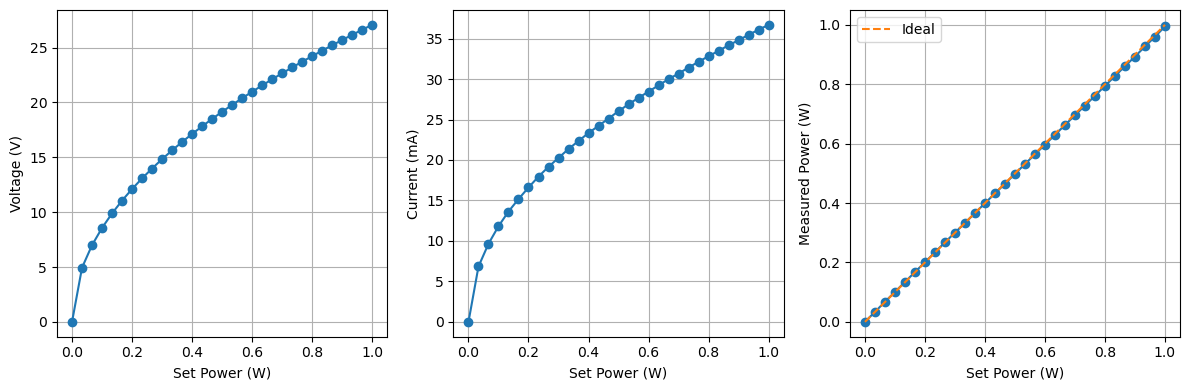

In [7]:
# Test the new set_power() method with auto-calibration
shifter = kbench.PhaseShifter(17)

power_range = np.linspace(0, 1, 31)

real_voltage = np.empty_like(power_range)
real_current = np.empty_like(power_range)
real_power = np.empty_like(power_range)

for i, p in enumerate(power_range):
    shifter.set_power(p)
    real_voltage[i] = shifter.get_voltage()
    real_current[i] = shifter.get_current()
    real_power[i] = shifter.get_power()

print(real_current, real_voltage, real_power)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(power_range, real_voltage, '-o')
axs[0].set_ylabel("Voltage (V)")
axs[0].set_xlabel("Set Power (W)")
axs[0].grid()

axs[1].plot(power_range, real_current, '-o')
axs[1].set_ylabel("Current (mA)")
axs[1].set_xlabel("Set Power (W)")
axs[1].grid()

axs[2].plot(power_range, real_power, '-o')
axs[2].plot(power_range, power_range, '--', label='Ideal')
axs[2].set_ylabel("Measured Power (W)")
axs[2].set_xlabel("Set Power (W)")
axs[2].legend()
axs[2].grid()
plt.tight_layout()
plt.show()


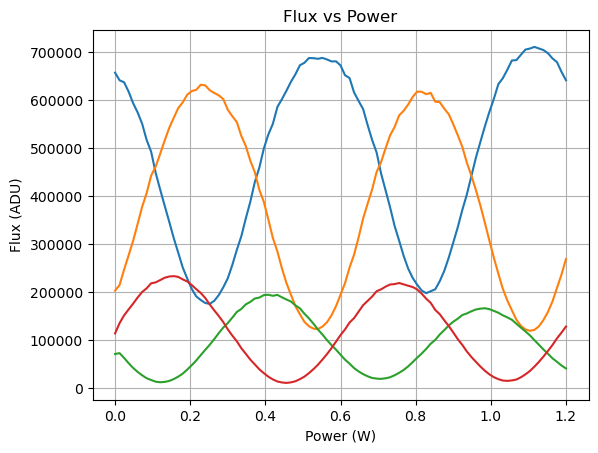

In [8]:
# Data acquisition
flux = []
for power in ramp:
    shifter.set_power(power)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Power (W)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Power")
plt.grid()
plt.show()

sleep(3)
shifter.turn_off()

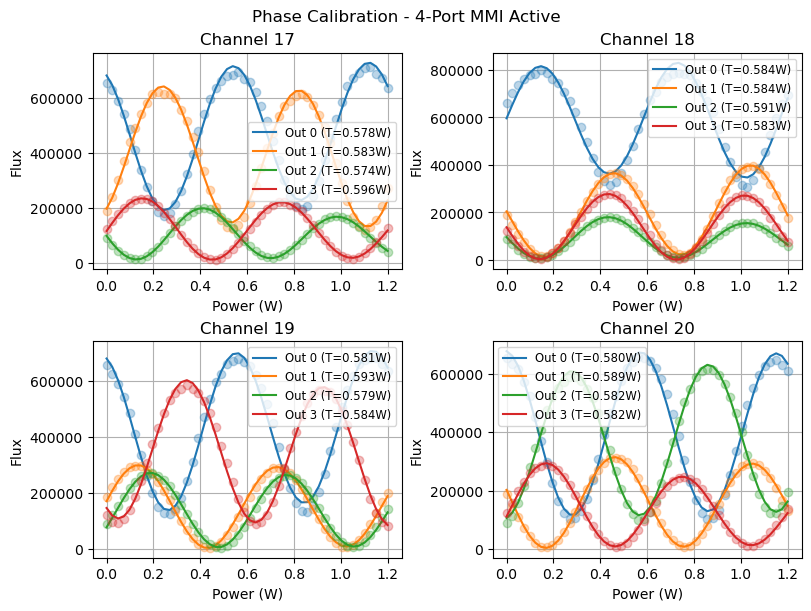

In [9]:
arch.calibrate_phase(samples=50, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

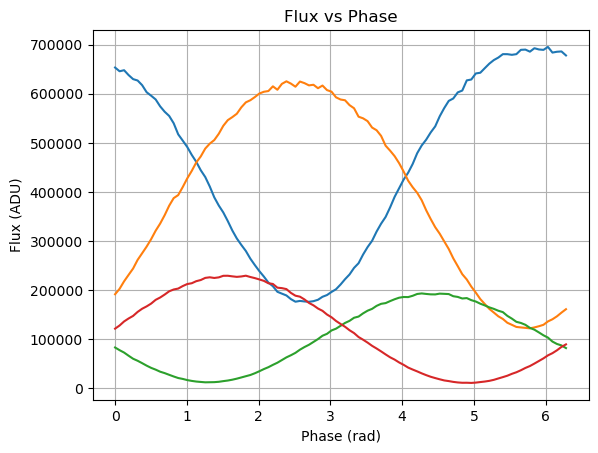

In [10]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux = []
for shift in ramp:
    shifter.set_phase(shift)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Phase (rad)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Phase")
plt.grid()
plt.show()